这里使用的决策树模型为本项目中实现的决策树模型

In [1]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import copy

class Bagging:

    def __init__(self,rate = 0.63,feature_rate = 1,n_estimators = 100,samping_type = "underSampling"):
        pass
        """
         rate 设置采样的比例（选取原样本的多少个数据）
         n_estimators 设置基础模型的数量 
         samping_type 设置采样的方式
         args 是给每个基础训练模型设置的参数
        """
        self.rate = rate
        self.feature_rate = feature_rate
        self.n_estimators = n_estimators
        self.samping_type = samping_type

    def underSampling(self,samples):
        pass
        """
            欠采样
            参数samples是需要被采样的训练集（其中包含了标签集）
        """
        data = np.array(samples).copy()
        np.random.shuffle(data)
        #采样的实例
        new_samples = data[0:int(data.shape[0] * self.rate)]
        #包外实例
        oob_samples = data[int(data.shape[0] * self.rate):data.shape[0]]

        return new_samples,oob_samples

    def bootstrap_Sampling(self,samples):
        pass
        """简单有放回采样"""
        new_samples = []
        n_samples,n_features = samples.shape
        for i in range(int(n_samples * self.rate)):
            new_samples.append(samples[np.random.randint(0,n_samples-1)])
        new_samples = np.array(new_samples)

        #求差集，差集即为包外实例
        a1_rows = samples.view([('', samples.dtype)] * n_features)
        a2_rows = new_samples.view([('', samples.dtype)] * n_features)
        oob_samples = np.setdiff1d(a1_rows,a2_rows).view(samples.dtype).reshape(-1,n_features)
        return new_samples,oob_samples

    def _feature_sampling(self,X_new):
        pass
        """
            对特征进行随机采样
            这里的处理方式是将没有采样到的特征列全部置为0（这里是产生一个随机被置为0的列的索引数组）
        """
        #产生一个大小为 int(self.n_features - self.n_features * self.feature_rate)的不重复随机数组，数组的范围是0 - self.n_features
        idx = np.random.choice(a=self.n_features,size= int(self.n_features - self.n_features * self.feature_rate),replace=False)
        #把选择到的特征列置为0，相当于此列不起作用
        X_new[:,idx] = 0
        return X_new

    def voting(self):
        pass
        """
        对结果集投票
        分类任务选择结果的众数
        回归任务选择结果的平均值
        """
        return NotImplemented()

    def _set_y_dtype(self,y):
        pass
        """这个函数在分类任务里面需要进行重写，求众数的bincount函数需要数据类型为int"""
        return y

    def _train_thread(self,model,samples):
        pass
        """
         第一重随机性：对训练数据进行随机采样
        """
        if self.samping_type == "bootstrap_Sampling":
            new_samples,_ = self.bootstrap_Sampling(samples)
        else:
            new_samples,_ = self.underSampling(samples)
        X_new = new_samples[:,0:self.n_features]
        y_new = new_samples[:,self.n_features]
        #这一块设置数据类型
        y_new = self._set_y_dtype(y_new)

        """第二重随机性：对特征进行随机采样"""
        X_new = self._feature_sampling(X_new)

        model.fit(X_new,y_new)


    def fit(self,X,y):
        pass
        """进行模型训练"""
        samples = np.c_[X,y[:np.newaxis]]
        self.n_features = X.shape[1]
        #保存训练好的模型结果
        self._estimators = []

        #使用多线程并行计算，加快速度
        threadPool = ThreadPoolExecutor(max_workers=4)
        for i in range(self.n_estimators):
            #每次创建一个新的基础模型，然后用新的基础模型去训练采样的数据
            estimator = copy.deepcopy(self.estimator)
            #使用线程池创建一个新的线程运行单个模型训练
            f = threadPool.submit(self._train_thread,estimator,samples)
            #保存此次的训练好的模型
            self._estimators.append(estimator)

        threadPool.shutdown()


    def predict(self,X_test):
        pass
        results = np.empty((self.n_estimators,X_test.shape[0]))

        #使用多线程分别计算不同的基础模型的预测结果
        max_workers = 4
        threadPool = ThreadPoolExecutor(max_workers=max_workers)
        for i in range(0,self.n_estimators,max_workers):
            jobs = []
            size = max_workers if max_workers <= self.n_estimators-i else self.n_estimators-i
            for j in range(size):
                futures = threadPool.submit(self._estimators[i+j].predict,X_test)
                #print(self._estimators[i+j].nodes_nums())
                jobs.append(futures)
            for j in range(size):
                results[i+j] = jobs[j].result()

        threadPool.shutdown()
        y_predict = self.voting(results)
        return np.array(y_predict)



class BaggingClassifer(Bagging):

    def __init__(self,estimator,rate = 0.63,feature_rate = 1,n_estimators = 100,samping_type = "bootstrap_Sampling"):
        pass
        """
         rate 设置采样的比例（选取原样本的多少个数据）
         n_estimators 设置基础模型的数量 
         samping_type 设置采样的方式
        """
        Bagging.__init__(self,rate = rate,feature_rate = feature_rate,n_estimators = n_estimators,samping_type = samping_type)

        """
            estimator 训练的基础模型  
        """
        self.estimator = estimator


    def _set_y_dtype(self,y):
        return np.array(y,dtype='int')

    def voting(self,results):
        pass
        """
            选取结果集中的众数
        """
        results = self._set_y_dtype(results)
        res = np.empty(results.shape[1],dtype='int')
        #对每一列求众数
        for i in range(results.shape[1]):
            counts = np.bincount(results[:,i])
            mode = np.argmax(counts)
            res[i] = mode
        return res



class BaggingRegression(Bagging):
    pass

    def __init__(self,estimator,rate = 0.63,feature_rate=1,n_estimators = 100,samping_type = "bootstrap_Sampling"):
        pass
        """
         rate 设置采样的比例（选取原样本的多少个数据）
         n_estimators 设置基础模型的数量 
         samping_type 设置采样的方式
        """
        Bagging.__init__(self,rate = rate,feature_rate = feature_rate,n_estimators = n_estimators,samping_type = samping_type)

        """
            estimator 训练的基础模型  
        """
        self.estimator = estimator


    def voting(self,results):
        pass
        """
            选取结果集中平均数
        """
        res = np.empty(results.shape[1])
        #对每一列平均数
        for i in range(results.shape[1]):
            mean = results[:,i].mean()
            res[i] = mean
        return res


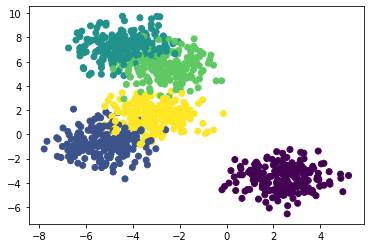

In [9]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from DecisionTree import CARTClassification,CARTRegression
np.set_printoptions(suppress=True)

x_samples,y_samples = make_blobs(centers=5,n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(x_samples, y_samples)
plt.scatter(x_samples[:,0],x_samples[:,1],c=y_samples)
plt.show()


In [10]:
cart = CARTClassification()
cart.fit(X_train,y_train)
cart.prune()
y_predict = cart.predict(X_test)
print("结点数量：",cart.nodes_nums())
print("单个决策树的预测正确率：",np.sum(y_predict == y_test)/len(y_test)*100,"%")
print("======cart正常使用======")
baggingClassifer = BaggingClassifer(CARTClassification(),n_estimators=33,rate=0.7,feature_rate=1,samping_type="bootstrap_Sampling")
baggingClassifer.fit(X_train,y_train)
new_y_predict = baggingClassifer.predict(X_test)

print("使用决策森林的预测正确率",np.sum(new_y_predict == y_test)/len(y_test)*100,"%")


结点数量： (83, 42)
单个决策树的预测正确率： 90.4 %
======cart正常使用======
使用决策森林的预测正确率 92.0 %


单个树的节点数量和叶节点数量： (173, 87)


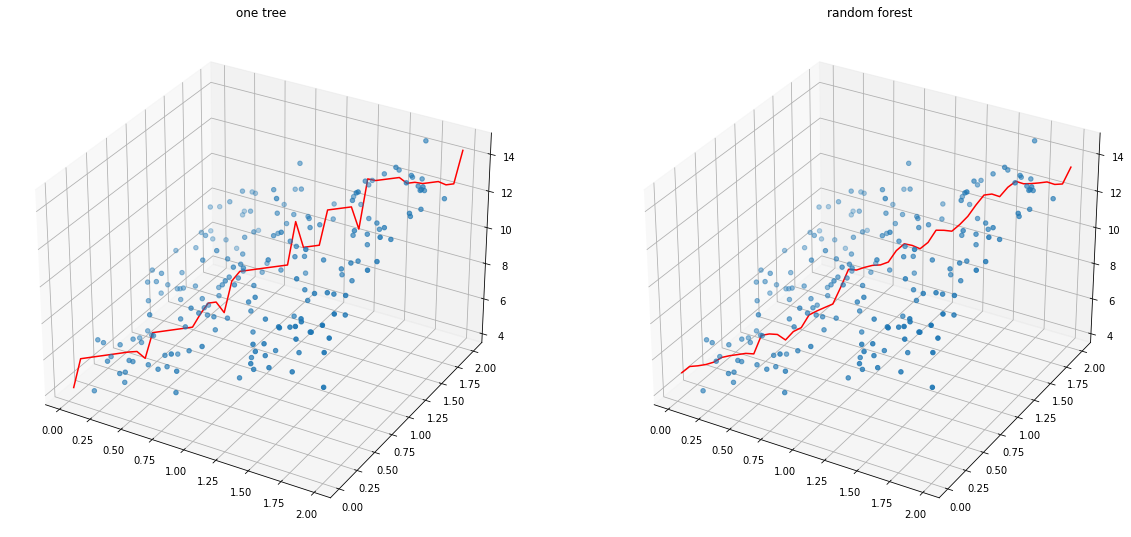

In [17]:
m=200
X = 2 * np.random.rand(m,2) # X 是列向量
y = 4 +3*X[:,0:1] + 2*X[:,1:2] +np.random.randn(m,1) #Y 也是列向量
y = y.ravel()

myCARTR = CARTRegression(min_sample=5)
myCARTR.fit(X,y)
print("单个树的节点数量和叶节点数量：",myCARTR.nodes_nums())
X1_new = np.linspace(np.min(X[:,0]),np.max(X[:,0]),50)[:,np.newaxis]
X2_new = np.linspace(np.min(X[:,1]),np.max(X[:,1]),50)[:,np.newaxis]
X_new = np.c_[X1_new,X2_new]

y_new = myCARTR.predict(X_new)

fig = plt.figure(figsize=(20, 20.5))
ax1 = fig.add_subplot(121,projection='3d')
plt.title("one tree")
ax1.scatter3D(X[:,0],X[:,1],y, cmap='Blues')
ax1.plot3D(X_new[:,0],X_new[:,1],y_new,'red')

baggingRegression = BaggingRegression(CARTRegression(min_sample=5),n_estimators=100,rate=0.8,feature_rate=1)
baggingRegression.fit(X,y)
y_new = baggingRegression.predict(X_new)
ax2 = fig.add_subplot(122,projection='3d')
plt.title("random forest")
ax2.scatter3D(X[:,0],X[:,1],y, cmap='Blues')
ax2.plot3D(X_new[:,0],X_new[:,1],y_new,'red')
plt.show()

这个例子其实没有体现到随机森林的第二重随机性：特征随机选择，训练数据集的特征太少，随机森林进行如果要特征随机选择的话只能从两个特征中选择一个。